In [15]:
import warnings
warnings.filterwarnings("ignore")
import multiprocessing
from multiprocessing.pool import ThreadPool
import pandas as pd
import numpy as np
from tqdm import tqdm,tqdm_notebook
from prettytable import PrettyTable
import pickle
import os
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["axes.grid"] = False
from PIL import Image
import cv2
from sklearn.model_selection import train_test_split
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.cm import get_cmap
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
print('CWD is ',os.getcwd())

CWD is  C:\Users\Yam\Desktop\real


In [16]:
dataset_path = os.listdir('fundus')
fundus_types = os.listdir('fundus')
print(fundus_types)
print("types of fundus found: ", len(fundus_types))

['cmv', 'normal', 'other', 'unknown']
types of fundus found:  4


In [17]:
df= []
for item in fundus_types:
    all_fundus = os.listdir('fundus'+'/'+item)
    for fundus in all_fundus:
        split_id = str(fundus).split('.')
        df.append((split_id[0],item,str('fundus/'+item)+'/'+fundus,str(fundus)))
df = pd.DataFrame(data=df, columns=['id_code','diagnosis','file_path','file_name'])
df.to_csv(r'C:\Users\Yam\Desktop\real\fundus.csv', index = False, header=True)
df.head()

id_code diagnosis               file_path    file_name
0  009-cmv       cmv  fundus/cmv/009-cmv.jpg  009-cmv.jpg
1  023-cmv       cmv  fundus/cmv/023-cmv.jpg  023-cmv.jpg
2  030-cmv       cmv  fundus/cmv/030-cmv.jpg  030-cmv.jpg
3  037-cmv       cmv  fundus/cmv/037-cmv.jpg  037-cmv.jpg
4  039-cmv       cmv  fundus/cmv/039-cmv.jpg  039-cmv.jpg

In [18]:
print("Total number of fundus in the dataset: ", len(df))
df_count = df['diagnosis'].value_counts()
print("fundus in each category: ")
print(df_count)

Total number of fundus in the dataset:  165
fundus in each category: 
normal     124
cmv         27
other        9
unknown      5
Name: diagnosis, dtype: int64


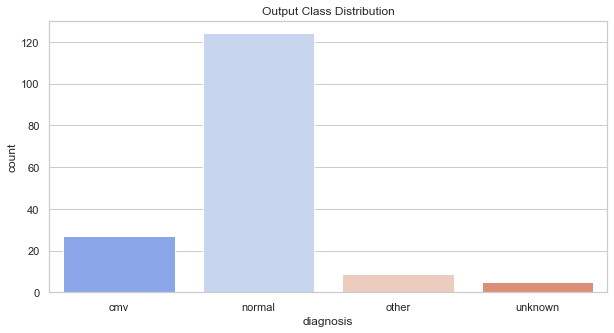

In [19]:
df_group = pd.DataFrame(df.groupby('diagnosis').agg('size').reset_index())
df_group.columns = ['diagnosis','count']

sns.set(rc={'figure.figsize':(10,5)}, style = 'whitegrid')
sns.barplot(x = 'diagnosis',y='count',data = df_group,palette = "coolwarm")
plt.title('Output Class Distribution')
plt.show() 

In [20]:
def conv_gray(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    #img = cv2.resize(img,(1000,750))
    return img

def visualize_imgs(df,pts_per_class,color_scale):
    df = df.groupby('diagnosis',group_keys = False).apply(lambda df: df.sample(pts_per_class))
    df = df.reset_index(drop = True)
    
    plt.rcParams["axes.grid"] = False
    for pt in range(pts_per_class):
        f, ax = plt.subplots(1,4,figsize = (15,15))
        ax[0].set_ylabel("Sample Data Points")
        #arrange class 
        df_temp = df[df.index.isin([pt + (pts_per_class*0),pt + (pts_per_class*1), pt 
                                    + (pts_per_class*2),pt + (pts_per_class*3)])]
        for i in range(4):
            if color_scale == 'gray':
                img = conv_gray(cv2.imread(df_temp.file_path.iloc[i]))
                ax[i].imshow(img,cmap = color_scale)
            else:
                ax[i].imshow(Image.open(df_temp.file_path.iloc[i]))
            ax[i].set_xlabel('Class '+str(df_temp.diagnosis.iloc[i]))

        plt.show()

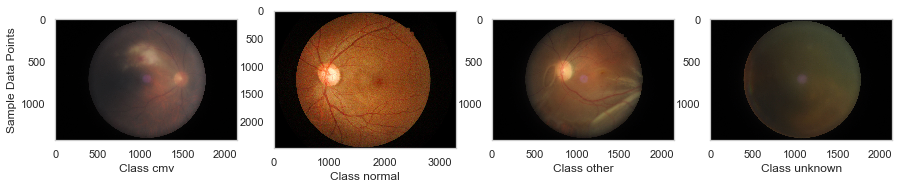

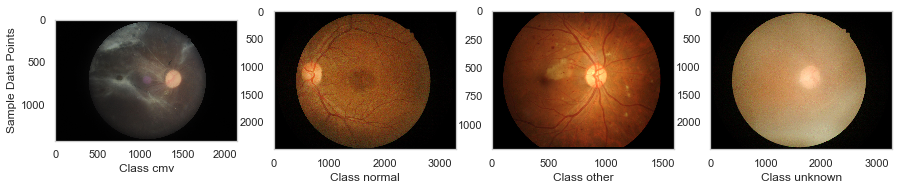

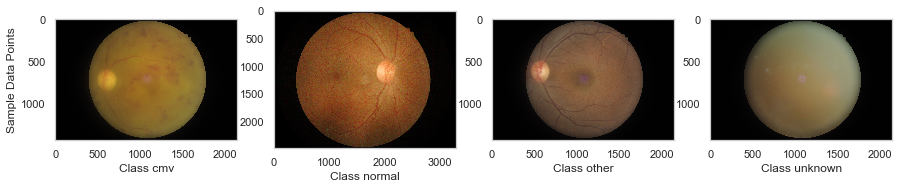

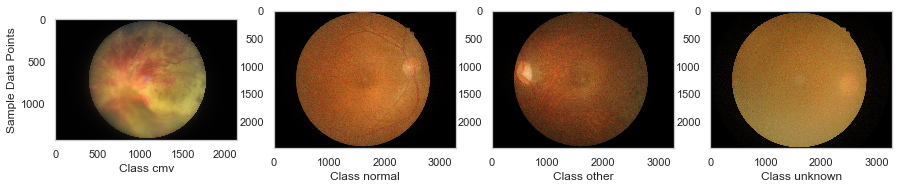

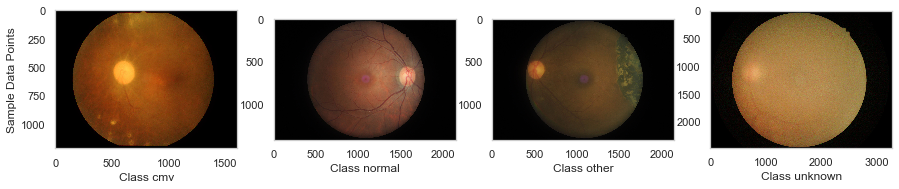

In [21]:
visualize_imgs(df,5,color_scale = None)

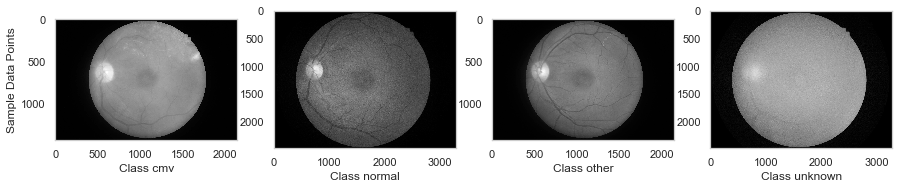

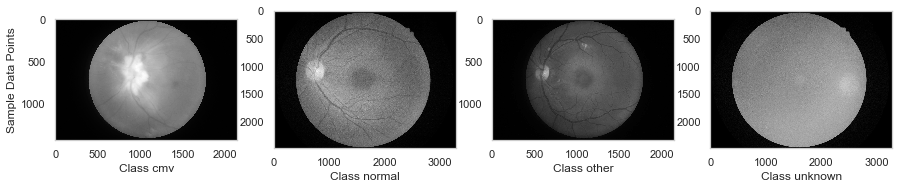

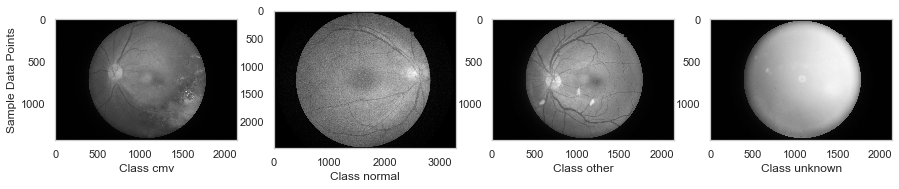

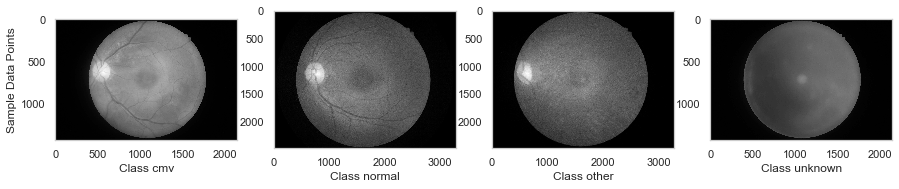

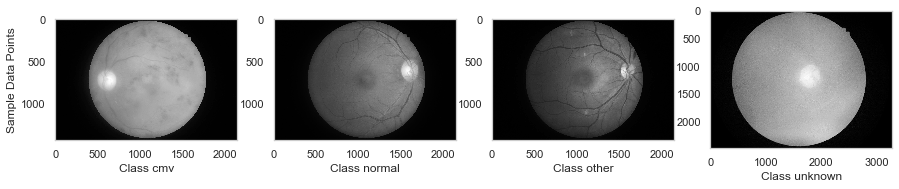

In [22]:
visualize_imgs(df,5,color_scale = 'gray')

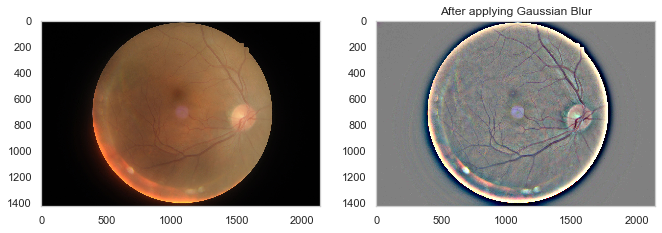

In [23]:
#random picture
rn = np.random.randint(low = 0,high = len(df) - 1)
img = cv2.imread(df.file_path.iloc[rn])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_t = cv2.addWeighted(img,4, cv2.GaussianBlur(img , (0,0) , 30) ,-4 ,128)

f, ax = plt.subplots(1,2,figsize = (11,11))
ax[0].imshow(img)
ax[1].imshow(img_t)
plt.title('After applying Gaussian Blur')
plt.show()

In [24]:
def crop_image_from_gray(img,tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
            # print(img1.shape,img2.shape,img3.shape)
            img = np.stack([img1,img2,img3],axis=-1)
            # print(img.shape)
        return img
    
    
def circle_crop(img, sigmaX):   
    #to crop image photo
    img = crop_image_from_gray(img)    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    height, width, depth = img.shape    
    
    x = int(width/2)
    y = int(height/2)
    r = np.amin((x,y))
    
    circle_img = np.zeros((height, width), np.uint8)
    cv2.circle(circle_img, (x,y), int(r), 1, thickness=-1)
    img = cv2.bitwise_and(img, img, mask=circle_img)
    img = crop_image_from_gray(img)
    img=cv2.addWeighted(img,4, cv2.GaussianBlur( img , (0,0) , sigmaX) ,-4 ,128)
    return img 



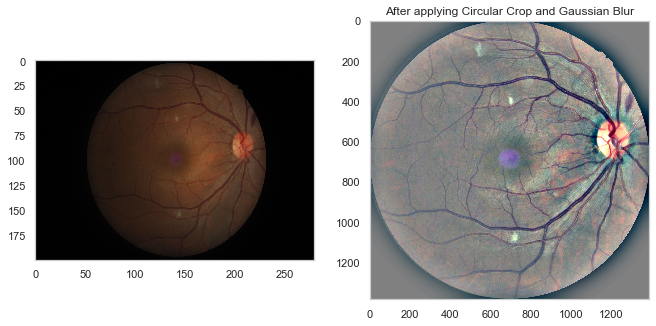

In [25]:
#random picture
rn = np.random.randint(low = 0,high = len(df) - 1)
img = cv2.imread(df.file_path.iloc[rn])
img_t = circle_crop(img,sigmaX = 50)

f, ax = plt.subplots(1,2,figsize = (11,11))
ax[0].imshow(cv2.resize(cv2.cvtColor(img, cv2.COLOR_BGR2RGB),(280,200)))
ax[1].imshow(img_t)
plt.title('After applying Circular Crop and Gaussian Blur')
plt.show()

In [26]:
def conv_gray(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    #img = cv2.resize(img,(1000,750))
    return img

def crop_image_from_gray(img,tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
            # print(img1.shape,img2.shape,img3.shape)
            img = np.stack([img1,img2,img3],axis=-1)
            # print(img.shape)
        return img
    
def circle_crop_ori(img):   
    #to crop image photo
    img = crop_image_from_gray(img)    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    height, width, depth = img.shape    
    
    x = int(width/2)
    y = int(height/2)
    r = np.amin((x,y))
    
    circle_img = np.zeros((height, width), np.uint8)
    cv2.circle(circle_img, (x,y), int(r), 1, thickness=-1)
    img = cv2.bitwise_and(img, img, mask=circle_img)
    img = crop_image_from_gray(img)
    return img 

def visualize_img_process_ori(df,pts_per_class):
    df = df.groupby('diagnosis',group_keys = False).apply(lambda df: df.sample(pts_per_class))
    df = df.reset_index(drop = True)
    
    plt.rcParams["axes.grid"] = False
    for pt in range(pts_per_class):
        f, ax = plt.subplots(1,4,figsize = (15,15))
        ax[0].set_ylabel("Sample Data Points")
        
        df_temp = df[df.index.isin([pt + (pts_per_class*0),pt + (pts_per_class*1), 
                                    pt + (pts_per_class*2),pt + (pts_per_class*3)])]
        for i in range(4):
            img = cv2.imread(df_temp.file_path.iloc[i])
            img = circle_crop_ori(img)
            ax[i].imshow(img)
            ax[i].set_xlabel('Class '+str(df_temp.diagnosis.iloc[i]))

        plt.show()

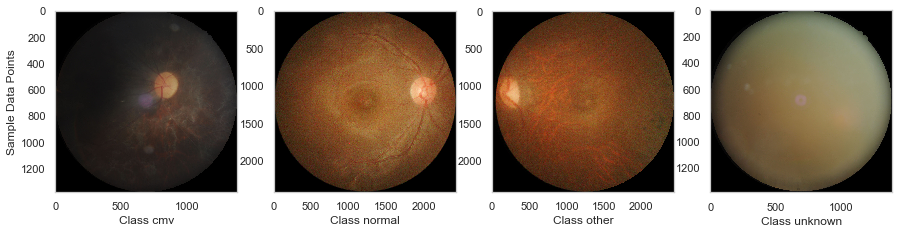

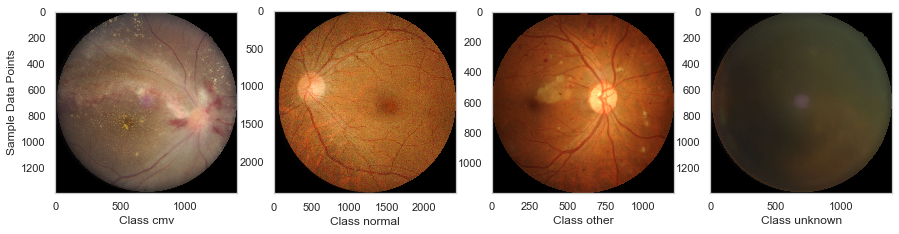

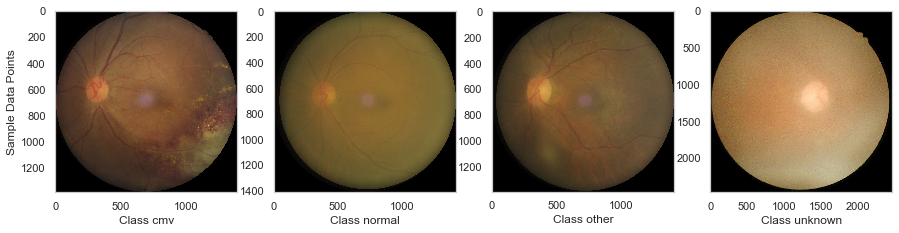

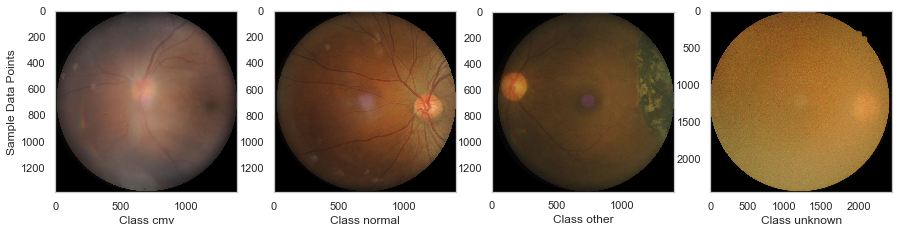

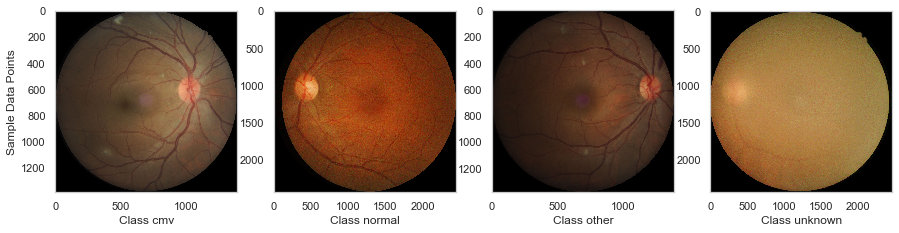

In [27]:
visualize_img_process_ori(df,5)

In [28]:
def visualize_img_process(df,pts_per_class,sigmaX):
    df = df.groupby('diagnosis',group_keys = False).apply(lambda df: df.sample(pts_per_class))
    df = df.reset_index(drop = True)
    
    plt.rcParams["axes.grid"] = False
    for pt in range(pts_per_class):
        f, ax = plt.subplots(1,4,figsize = (15,15))
        ax[0].set_ylabel("Sample Data Points")
        
        df_temp = df[df.index.isin([pt + (pts_per_class*0),pt + (pts_per_class*1), 
                                    pt + (pts_per_class*2),pt + (pts_per_class*3)])]
        for i in range(4):
            img = cv2.imread(df_temp.file_path.iloc[i])
            img = circle_crop(img,sigmaX)
            ax[i].imshow(img)
            ax[i].set_xlabel('Class '+str(df_temp.diagnosis.iloc[i]))

        plt.show()

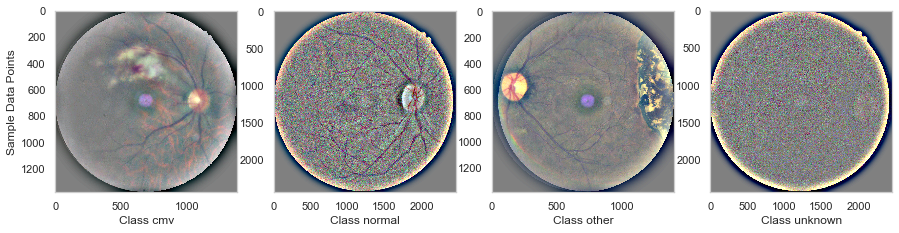

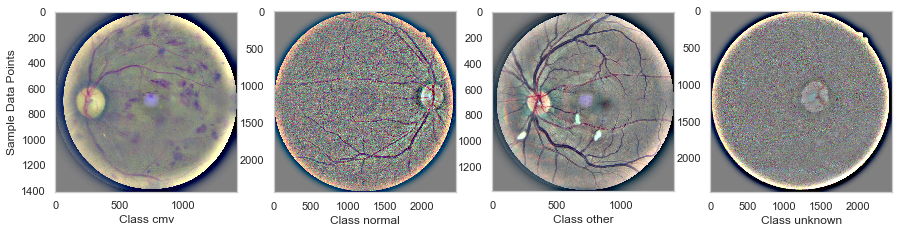

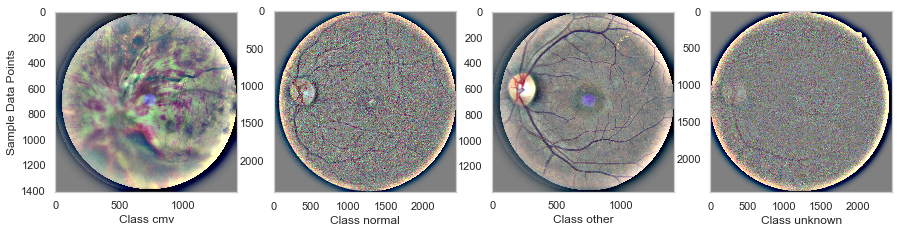

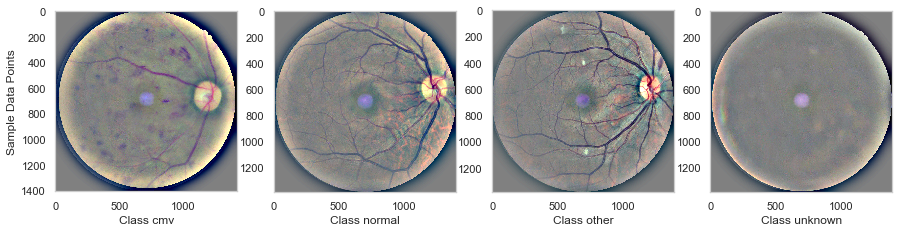

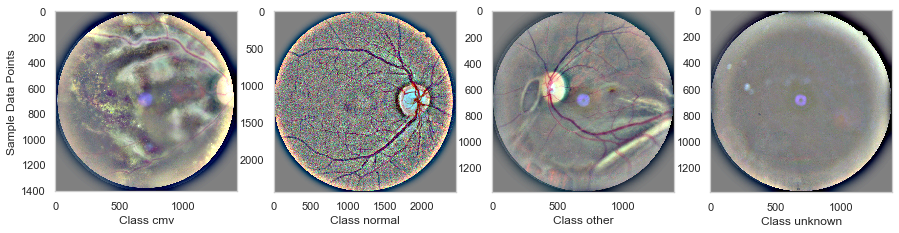

In [29]:
visualize_img_process(df,5,sigmaX = 50)

In [30]:
npix = 224 # resize to npix x npix (for now)
X_train = np.zeros((df.shape[0], npix, npix))
for i in tqdm_notebook(range(df.shape[0])):
    # load an image
    img = cv2.imread(df.file_path.iloc[i])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 
    X_train[i, :, :] = cv2.resize(img, (npix, npix)) 
    
print("X_train shape: " + str(np.shape(X_train)))   


X_train shape: (165, 224, 224)


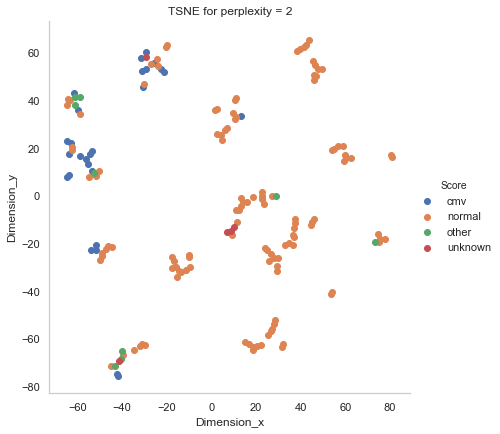

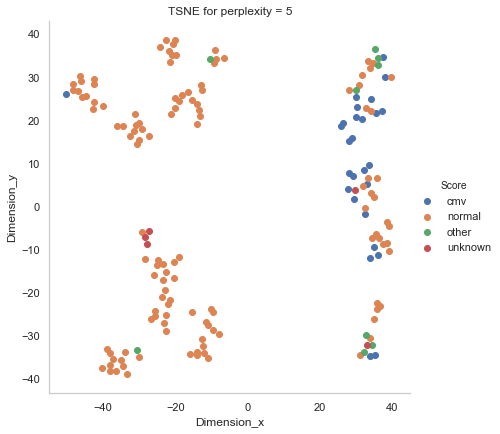

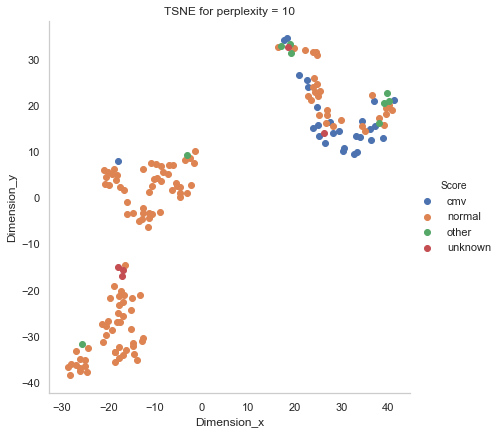

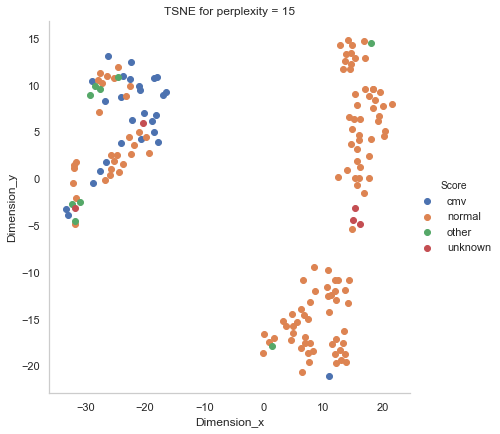

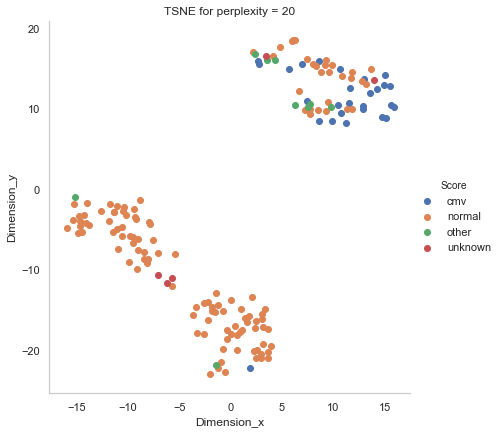

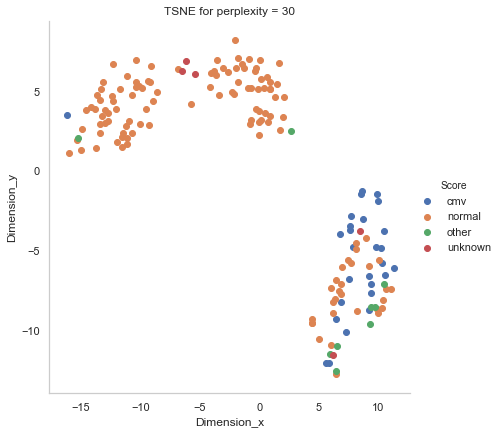

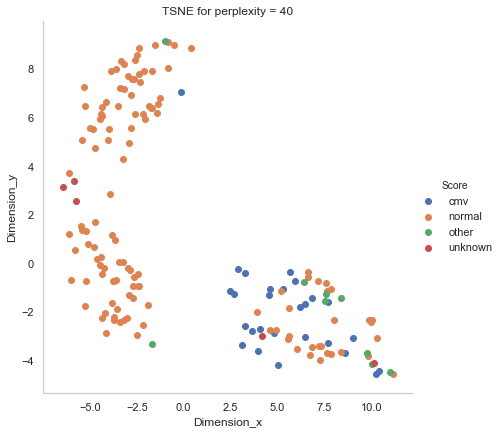

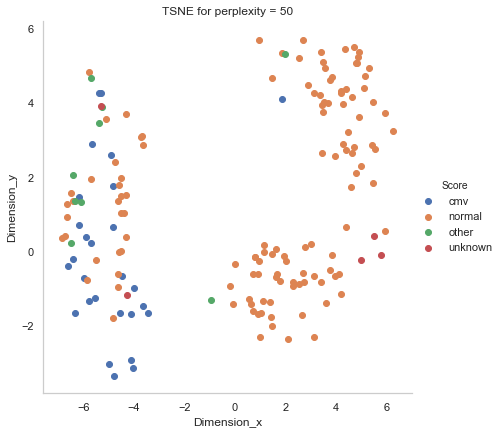

In [31]:
# normalize
X = X_train / 255

# reshape
X = X.reshape(X.shape[0], -1)
trainy = df['diagnosis']
per_vals = [2,5,10,15,20,30,40,50]

for per in tqdm_notebook(per_vals):
    X_decomposed = TSNE(n_components=2,perplexity = per).fit_transform(X)
    df_tsne = pd.DataFrame(data=X_decomposed, columns=['Dimension_x','Dimension_y'])
    df_tsne['Score'] = trainy.values
    
    sns.FacetGrid(df_tsne, hue='Score', size=6).map(plt.scatter, 'Dimension_x', 'Dimension_y').add_legend()
    plt.title('TSNE for perplexity = ' + str(per))
    plt.show()

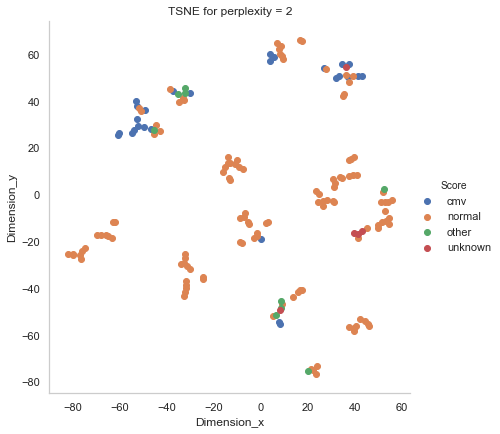

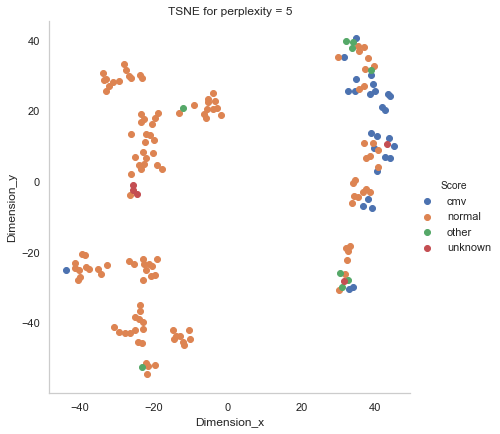

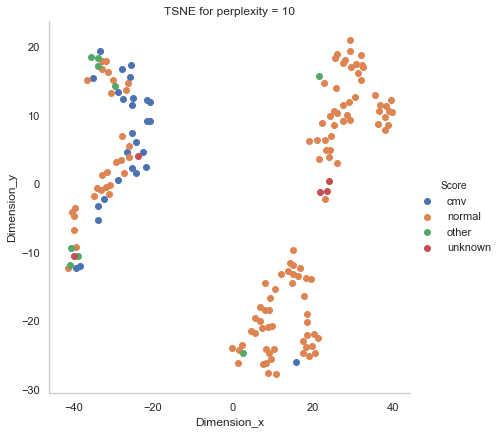

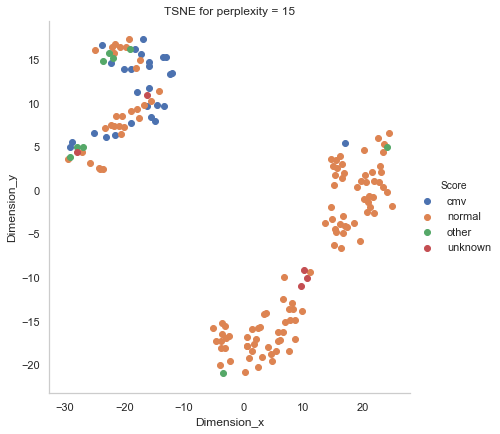

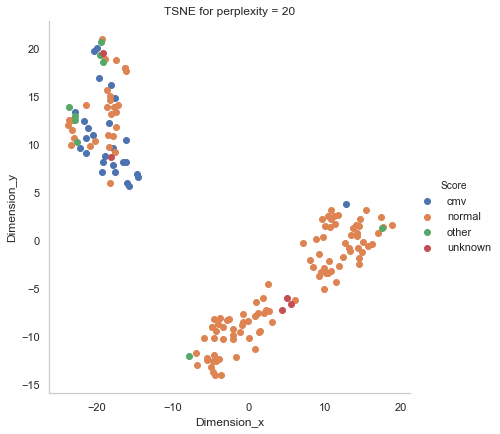

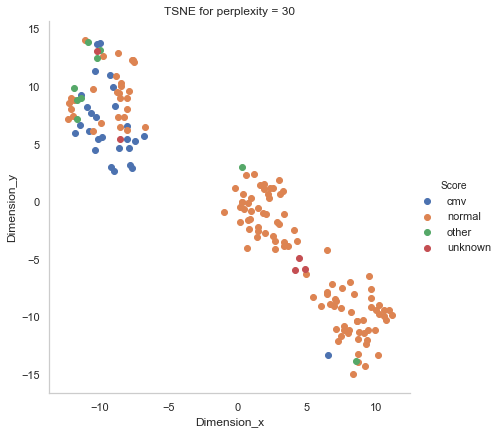

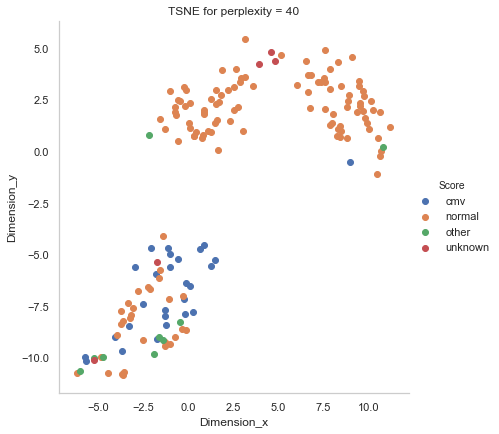

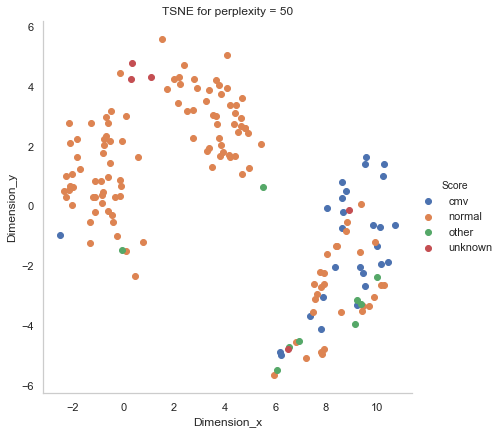

In [32]:
# normalize
X = X_train / 255

# reshape
X = X.reshape(X.shape[0], -1)
trainy = df['diagnosis']
per_vals = [2,5,10,15,20,30,40,50]

for per in tqdm_notebook(per_vals):
    X_decomposed = TSNE(n_components=2,perplexity = per).fit_transform(X)
    df_tsne = pd.DataFrame(data=X_decomposed, columns=['Dimension_x','Dimension_y'])
    df_tsne['Score'] = trainy.values
    
    sns.FacetGrid(df_tsne, hue='Score', size=6).map(plt.scatter, 'Dimension_x', 'Dimension_y').add_legend()
    plt.title('TSNE for perplexity = ' + str(per))
    plt.show()